# **AIN422 Assignment 2**



### Library Imports

In [140]:
import gzip
import os
import numpy as np
import struct
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

### Data Operations

After importing the libraries, I am identifying the path. I am using Google Drive to reach train and test files of MNIST. I am extracting .gz files with this code below.

In [141]:
path = "/content/drive/MyDrive/MNIST/"

In [142]:
with gzip.open(path + 'train-images-idx3-ubyte.gz', 'rb') as f:
    train_images = np.frombuffer(f.read(), dtype=np.uint8, offset=16).reshape(-1, 28, 28)

with gzip.open(path + 'train-labels-idx1-ubyte.gz', 'rb') as f:
    train_labels = np.frombuffer(f.read(), dtype=np.uint8, offset=8)

with gzip.open(path + 't10k-images-idx3-ubyte.gz', 'rb') as f:
    test_images = np.frombuffer(f.read(), dtype=np.uint8, offset=16).reshape(-1, 28, 28)

with gzip.open(path + 't10k-labels-idx1-ubyte.gz', 'rb') as f:
    test_labels = np.frombuffer(f.read(), dtype=np.uint8, offset=8)

Here is my dataloader function from scratch. I load data batch by batch.

In [143]:
def dataloader(images, labels, batch_size):
    num_batches = int(np.ceil(len(images) / batch_size))
    for i in range(num_batches):
        batch_images = images[i*batch_size:(i+1)*batch_size]
        batch_labels = labels[i*batch_size:(i+1)*batch_size]
        yield batch_images, batch_labels

You can see that my dataloader function loads data by batch by batch and I chose batch size as 32. 

In [144]:
batch_size = 32
train_loader = dataloader(train_images, train_labels, batch_size)
test_loader = dataloader(test_images, test_labels, batch_size)
batch_images, batch_labels = next(train_loader)

Here is sample 32 batch.

In [145]:
for i in range(32):
    batch_images, batch_labels = next(train_loader)
    print(f"Batch {i + 1}: images shape = {batch_images.shape}, labels shape = {batch_labels.shape}")

Batch 1: images shape = (32, 28, 28), labels shape = (32,)
Batch 2: images shape = (32, 28, 28), labels shape = (32,)
Batch 3: images shape = (32, 28, 28), labels shape = (32,)
Batch 4: images shape = (32, 28, 28), labels shape = (32,)
Batch 5: images shape = (32, 28, 28), labels shape = (32,)
Batch 6: images shape = (32, 28, 28), labels shape = (32,)
Batch 7: images shape = (32, 28, 28), labels shape = (32,)
Batch 8: images shape = (32, 28, 28), labels shape = (32,)
Batch 9: images shape = (32, 28, 28), labels shape = (32,)
Batch 10: images shape = (32, 28, 28), labels shape = (32,)
Batch 11: images shape = (32, 28, 28), labels shape = (32,)
Batch 12: images shape = (32, 28, 28), labels shape = (32,)
Batch 13: images shape = (32, 28, 28), labels shape = (32,)
Batch 14: images shape = (32, 28, 28), labels shape = (32,)
Batch 15: images shape = (32, 28, 28), labels shape = (32,)
Batch 16: images shape = (32, 28, 28), labels shape = (32,)
Batch 17: images shape = (32, 28, 28), labels sha

### Data Visualizing

I am visualizing the first 10 train and test images. 

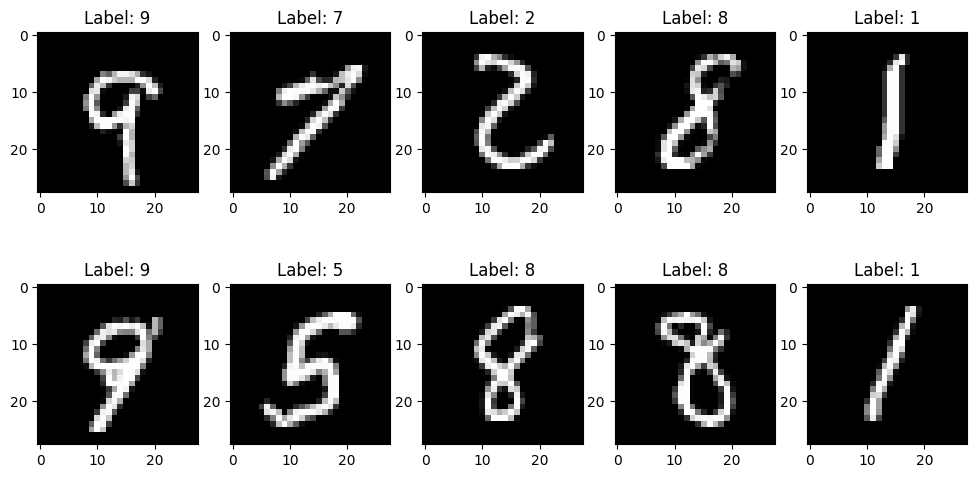

In [146]:
batch_images, batch_labels = next(train_loader)
fig, axs = plt.subplots(2, 5, figsize=(12, 6))
for i in range(10):
    row = i // 5
    col = i % 5
    axs[row, col].imshow(batch_images[i], cmap='gray')
    axs[row, col].set_title(f"Label: {batch_labels[i]}")
plt.show()

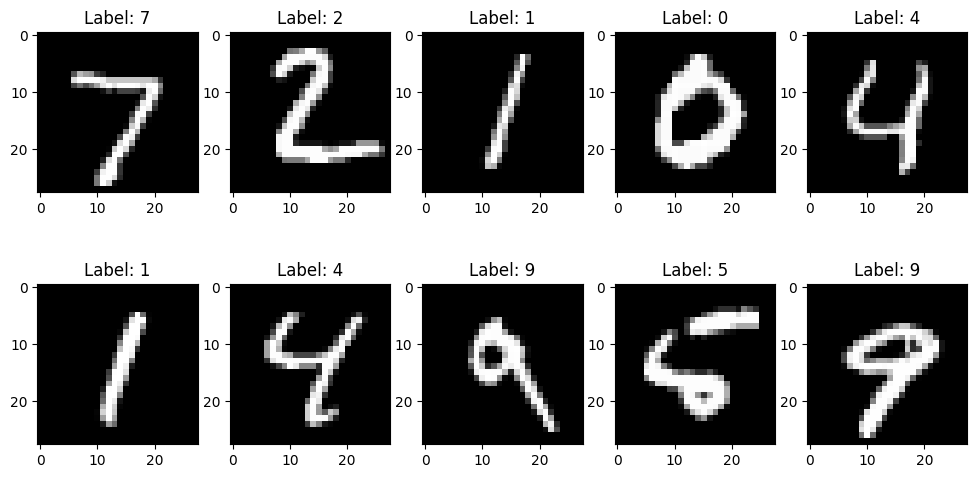

In [147]:
batch_images, batch_labels = next(test_loader)
fig, axs = plt.subplots(2, 5, figsize=(12, 6))
for i in range(10):
    row = i // 5
    col = i % 5
    axs[row, col].imshow(batch_images[i], cmap='gray')
    axs[row, col].set_title(f"Label: {batch_labels[i]}")
plt.show()

In this cell below, I am showing sample images for each labels.

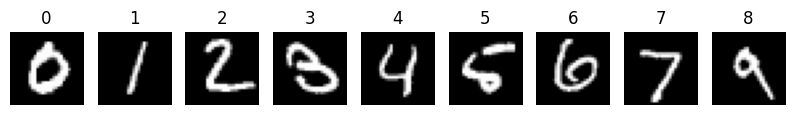

In [148]:
label_to_show = list(range(10))

images_to_show = []
for label in label_to_show:
    label_indices = np.where(batch_labels == label)[0]
    if len(label_indices) > 0:
        image_index = label_indices[0]
        image = batch_images[image_index]
        images_to_show.append(image)
fig, axs = plt.subplots(1, len(images_to_show), figsize=(10, 1))
for i, image in enumerate(images_to_show):
    axs[i].imshow(image.squeeze(), cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(str(label_to_show[i]))
plt.show()


You can see train and test labels distribution below, as visuaized with a pie graph.

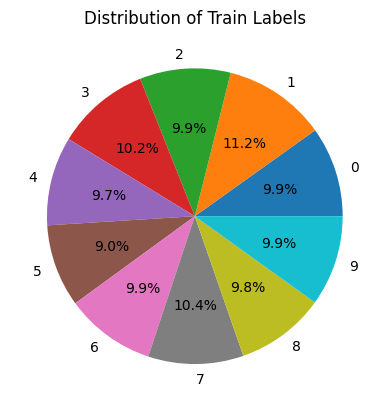

In [149]:
all_labels = []
for batch_images, batch_labels in train_loader:
    all_labels.extend(batch_labels)

label_counts = [all_labels.count(label) for label in set(all_labels)]
labels = list(set(all_labels))

plt.pie(label_counts, labels=labels, autopct='%1.1f%%')
plt.title("Distribution of Train Labels")
plt.show()

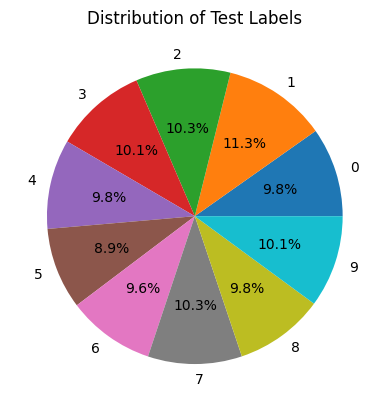

In [150]:
all_labels = []
for batch_images, batch_labels in test_loader:
    all_labels.extend(batch_labels)

label_counts = [all_labels.count(label) for label in set(all_labels)]
labels = list(set(all_labels))

plt.pie(label_counts, labels=labels, autopct='%1.1f%%')
plt.title("Distribution of Test Labels")
plt.show()

### Data Preprocessing

I decided to concat all images after using dataloader. I applied normalization to images and one hot encoding to labels in preprocessing part. 

After all operations I had train_images, train_labels, test_images, test_labels.

In [151]:
def preprocess_data(images, labels):
    images = tf.cast(images, tf.float32)
    images = images / 255.0
    labels = tf.one_hot(labels, depth=10)
    
    return images, labels

Here, I am loading images again. Because visualization part spent some batches. I am loading them again.

In [152]:
batch_size = 32
train_loader = dataloader(train_images, train_labels, batch_size)
test_loader = dataloader(test_images, test_labels, batch_size)
batch_images, batch_labels = next(train_loader)

I am preparing my data here. 

In [153]:
train_images, train_labels = [], []
for batch_images, batch_labels in train_loader:
    batch_images, batch_labels = preprocess_data(batch_images, batch_labels)
    train_images.append(batch_images)
    train_labels.append(batch_labels)
train_images = tf.concat(train_images, axis=0)
train_labels = tf.concat(train_labels, axis=0)

test_images, test_labels = [], []
for batch_images, batch_labels in test_loader:
    batch_images, batch_labels = preprocess_data(batch_images, batch_labels)
    test_images.append(batch_images)
    test_labels.append(batch_labels)
test_images = tf.concat(test_images, axis=0)
test_labels = tf.concat(test_labels, axis=0)
test_images = test_images[:10000]
test_labels = test_labels[:10000]

Here are shapes of train and test parts.

In [154]:
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(59968, 28, 28)
(59968, 10)
(10000, 28, 28)
(10000, 10)


### Parameter Tuning

First, I tried 3 batch sizes, 2 activation functions, 2 learning rates as parameters. After choosing parameters I will try 1-2-3 conv layers and I will decide my CNN architecture.

In [155]:
batch_sizes = [16, 32, 64]
activation_functions = ['relu', 'sigmoid']
learning_rates = [0.001, 0.01]

accuracy_results = []
loss_results = []
test_accuracy_results = []
test_loss_results = []
used_batch = []
used_act = []
used_lr = []
train_labels = tf.argmax(train_labels, axis=1)

for batch_size in batch_sizes:
    for activation_function in activation_functions:
        for learning_rate in learning_rates:
            model = tf.keras.Sequential()
            model.add(tf.keras.layers.Conv2D(32, (3, 3), activation=activation_function, input_shape=(28, 28, 1)))
            model.add(tf.keras.layers.MaxPooling2D((2, 2)))
            model.add(tf.keras.layers.Flatten())
            model.add(tf.keras.layers.Dense(128, activation=activation_function))
            model.add(tf.keras.layers.Dense(10, activation='softmax'))
            optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
            model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
            history = model.fit(train_images, train_labels, batch_size=batch_size, epochs=10, verbose=0)
            accuracy_results.append(history.history['accuracy'])
            loss_results.append(history.history['loss'])
            print(f"Batch Size: {batch_size}, Activation Function: {activation_function}, Learning Rate: {learning_rate}")
            print(f"Test Accuracy: {history.history['accuracy'][-1]:.4f}")
            used_batch.append(batch_size)
            used_act.append(activation_function)
            used_lr.append(learning_rate)
            test_accuracy = history.history['accuracy'][-1]
            test_loss = history.history['loss'][-1]
            test_accuracy_results.append(test_accuracy)
            test_loss_results.append(test_loss)

Batch Size: 16, Activation Function: relu, Learning Rate: 0.001
Test Accuracy: 0.9988
Batch Size: 16, Activation Function: relu, Learning Rate: 0.01
Test Accuracy: 0.9904
Batch Size: 16, Activation Function: sigmoid, Learning Rate: 0.001
Test Accuracy: 0.8048
Batch Size: 16, Activation Function: sigmoid, Learning Rate: 0.01
Test Accuracy: 0.1003
Batch Size: 32, Activation Function: relu, Learning Rate: 0.001
Test Accuracy: 0.9985
Batch Size: 32, Activation Function: relu, Learning Rate: 0.01
Test Accuracy: 0.9930
Batch Size: 32, Activation Function: sigmoid, Learning Rate: 0.001
Test Accuracy: 0.8079
Batch Size: 32, Activation Function: sigmoid, Learning Rate: 0.01
Test Accuracy: 0.1024
Batch Size: 64, Activation Function: relu, Learning Rate: 0.001
Test Accuracy: 0.9984
Batch Size: 64, Activation Function: relu, Learning Rate: 0.01
Test Accuracy: 0.9929
Batch Size: 64, Activation Function: sigmoid, Learning Rate: 0.001
Test Accuracy: 0.2450
Batch Size: 64, Activation Function: sigmoid

This graph shows parameter changes epoch by epoch.

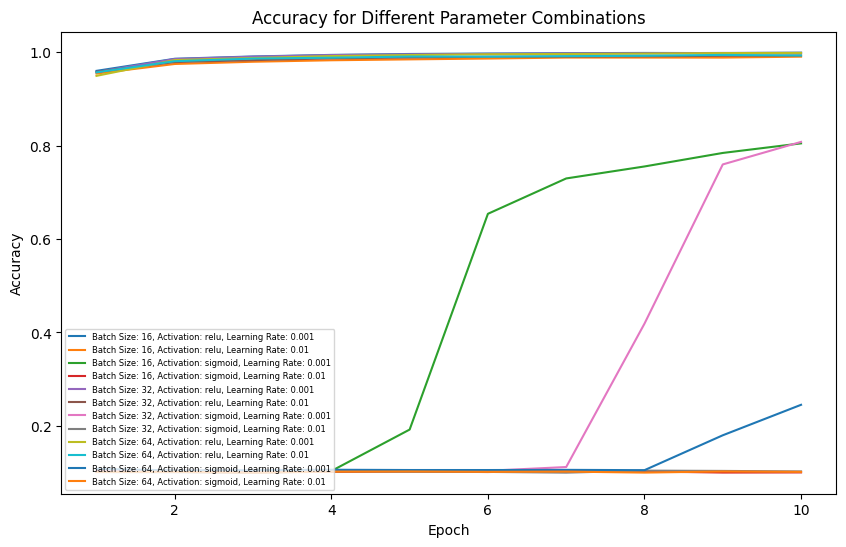

In [156]:
configurations = []
for i, accuracy in enumerate(accuracy_results):
    batch_size_index = i // (len(activation_functions) * len(learning_rates))
    activation_index = (i // len(learning_rates)) % len(activation_functions)
    learning_rate_index = i % len(learning_rates)
    configuration = f"Batch Size: {batch_sizes[batch_size_index]}, Activation: {activation_functions[activation_index]}, Learning Rate: {learning_rates[learning_rate_index]}"
    configurations.append(configuration)

plt.figure(figsize=(10, 6))
for i, accuracy in enumerate(accuracy_results):
    plt.plot(range(1, 11), accuracy, label=configurations[i])

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(fontsize=6, loc = "lower left")
plt.title('Accuracy for Different Parameter Combinations')
plt.show()


Now, we can see which model was the best with different parameters.

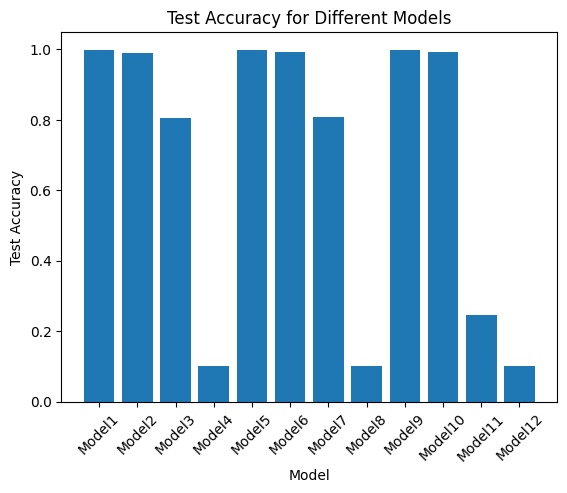

In [157]:
labels = ['Model1', 'Model2', 'Model3', 'Model4', 'Model5', 'Model6', 'Model7', 'Model8', 'Model9', 'Model10', 'Model11', 'Model12']
plt.bar(labels, test_accuracy_results)
plt.xlabel('Model')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy for Different Models')
plt.xticks(rotation=45)
plt.show()

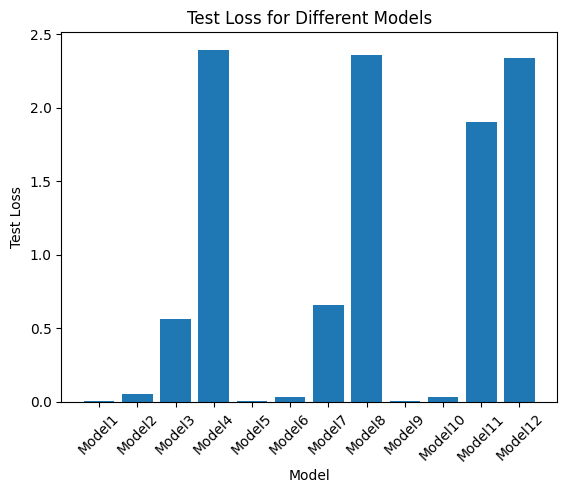

In [158]:
plt.bar(labels, test_loss_results)
plt.xlabel('Model')
plt.ylabel('Test Loss')
plt.title('Test Loss for Different Models')
plt.xticks(rotation=45)
plt.show()

### Chosen Parameters

I determined the first parameters according to the success of the models.

In [159]:
max_index = test_accuracy_results.index(max(test_accuracy_results))
chosen_batch = used_batch[max_index]
chosen_act = used_act[max_index]
chosen_lr = used_lr[max_index]

print("Best accuracy of models is:" , round(test_accuracy_results[max_index],4))
print("Best batch size is:" , chosen_batch)
print("Best activation function is:" , chosen_act)
print("Best learning rate is:" , chosen_lr)

Best accuracy of models is: 0.9988
Best batch size is: 16
Best activation function is: relu
Best learning rate is: 0.001


### Last Parameters: Layer Number and Layer Size

I tried other parameters, layer number and layer size in different cell. 
Because in for loop it causes more computation time, I wanted to try them seperately.

#### Layer Sizes

I tried 32,64 and 128 layer sizes.

In [160]:
layer_sizes = [32, 64, 128]

lay_accuracy_results = []
lay_loss_results = []
lay_test_accuracy_results = []
lay_test_loss_results = []
used_layer_size = []

for layer_size in layer_sizes:
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(layer_size, (3, 3), activation=chosen_act, input_shape=(28, 28, 1)))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation=chosen_act))
    model.add(tf.keras.layers.Dense(10, activation='softmax'))
    optimizer = tf.keras.optimizers.Adam(learning_rate=chosen_lr)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(train_images, train_labels, batch_size=chosen_batch, epochs=10, verbose=0)
    lay_accuracy_results.append(history.history['accuracy'])
    lay_loss_results.append(history.history['loss'])
    print(f"Layer Size: {layer_size}")
    print(f"Test Accuracy: {history.history['accuracy'][-1]:.4f}")
    used_layer_size.append(layer_size)
    lay_test_accuracy = history.history['accuracy'][-1]
    lay_test_loss = history.history['loss'][-1]
    lay_test_accuracy_results.append(lay_test_accuracy)
    lay_test_loss_results.append(lay_test_loss)

Layer Size: 32
Test Accuracy: 0.9988
Layer Size: 64
Test Accuracy: 0.9984
Layer Size: 128
Test Accuracy: 0.9985


In [161]:
max_index = lay_test_accuracy_results.index(max(lay_test_accuracy_results))
chosen_lay = used_layer_size[max_index]

print("Best accuracy of models is:" , round(lay_test_accuracy_results[max_index],4))
print("Best layer size is:" , chosen_lay)

Best accuracy of models is: 0.9988
Best layer size is: 32


#### Layer Numbers

I tried 1,2 and 3 number of convolutional layers. I have tried 1 conv layer above and didn't run it again. I worked with 2 and 3 conv layer models in this cell below.

In [162]:
conv_layer_num = [1,2,3]
laynum_accuracy_results = []
laynum_accuracy_results.append(lay_test_accuracy_results[max_index])

# 2 conv layer model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(chosen_lay, (3, 3), activation=chosen_act, input_shape=(28, 28, 1)))
model.add(tf.keras.layers.Conv2D(chosen_lay*2, (3, 3), activation=chosen_act))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation=chosen_act))
model.add(tf.keras.layers.Dense(10, activation='softmax'))
optimizer = tf.keras.optimizers.Adam(learning_rate=chosen_lr)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_images, train_labels, batch_size=chosen_batch, epochs=10, verbose=0)
print(f"Conv Layer Num: {conv_layer_num[1]}")
print(f"Test Accuracy: {history.history['accuracy'][-1]:.4f}")
lay_test_accuracy = history.history['accuracy'][-1]
laynum_accuracy_results.append(lay_test_accuracy)

# 3 conv layer model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(chosen_lay, (3, 3), activation=chosen_act, input_shape=(28, 28, 1)))
model.add(tf.keras.layers.Conv2D(chosen_lay*2, (3, 3), activation=chosen_act))
model.add(tf.keras.layers.Conv2D(chosen_lay*4, (3, 3), activation=chosen_act))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation=chosen_act))
model.add(tf.keras.layers.Dense(10, activation='softmax'))
optimizer = tf.keras.optimizers.Adam(learning_rate=chosen_lr)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_images, train_labels, batch_size=batch_size, epochs=10, verbose=0)
print(f"Conv Layer Num: {conv_layer_num[2]}")
print(f"Test Accuracy: {history.history['accuracy'][-1]:.4f}")
lay_test_accuracy = history.history['accuracy'][-1]
laynum_accuracy_results.append(lay_test_accuracy)

Conv Layer Num: 2
Test Accuracy: 0.9983
Conv Layer Num: 3
Test Accuracy: 0.9985


In [163]:
max_index = laynum_accuracy_results.index(max(laynum_accuracy_results))
chosen_num = conv_layer_num[max_index]

print("Best accuracy of models is:" , round(laynum_accuracy_results[max_index],4))
print("Best number of conv layers is:" , chosen_num)

Best accuracy of models is: 0.9988
Best number of conv layers is: 1


### Final CNN Architecture

After parameter tuning, my code places best chosen parameters dynamically. Here is my dynamic CNN architecture.

In [164]:
test_acc = []
test_loss = []
preds = []
def CNNModel(chosen_batch,chosen_act,chosen_lr,chosen_lay,chosen_num):
    if(chosen_num == 1):
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Conv2D(chosen_lay, (3, 3), activation=chosen_act, input_shape=(28, 28, 1)))
        model.add(tf.keras.layers.MaxPooling2D((2, 2)))
        model.add(tf.keras.layers.Flatten())
        model.add(tf.keras.layers.Dense(128, activation=chosen_act))
        model.add(tf.keras.layers.Dense(10, activation='softmax'))
        optimizer = tf.keras.optimizers.Adam(learning_rate=chosen_lr)
        model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        history = model.fit(train_images, train_labels, batch_size=chosen_batch, epochs=10, verbose=0)
        test_acc.append(history.history['accuracy'][-1])
        test_loss.append(history.history['loss'][-1])
        predictions = model.predict(test_images)
        preds.append(predictions)
    elif(chosen_num == 2):
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Conv2D(chosen_lay, (3, 3), activation=chosen_act, input_shape=(28, 28, 1)))
        model.add(tf.keras.layers.Conv2D(chosen_lay*2, (3, 3), activation=chosen_act))
        model.add(tf.keras.layers.MaxPooling2D((2, 2)))
        model.add(tf.keras.layers.Flatten())
        model.add(tf.keras.layers.Dense(128, activation=chosen_act))
        model.add(tf.keras.layers.Dense(10, activation='softmax'))
        optimizer = tf.keras.optimizers.Adam(learning_rate=chosen_lr)
        model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        history = model.fit(train_images, train_labels, batch_size=chosen_batch, epochs=10, verbose=0)
        test_acc.append(history.history['accuracy'][-1])
        test_loss.append(history.history['loss'][-1])
        predictions = model.predict(test_images)
        preds.append(predictions)
    elif(chosen_num == 3):
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Conv2D(chosen_lay, (3, 3), activation=chosen_act, input_shape=(28, 28, 1)))
        model.add(tf.keras.layers.Conv2D(chosen_lay*2, (3, 3), activation=chosen_act))
        model.add(tf.keras.layers.Conv2D(chosen_lay*4, (3, 3), activation=chosen_act))
        model.add(tf.keras.layers.MaxPooling2D((2, 2)))
        model.add(tf.keras.layers.Flatten())
        model.add(tf.keras.layers.Dense(128, activation=chosen_act))
        model.add(tf.keras.layers.Dense(10, activation='softmax'))
        optimizer = tf.keras.optimizers.Adam(learning_rate=chosen_lr)
        model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        history = model.fit(train_images, train_labels, batch_size=batch_size, epochs=10, verbose=0)
        test_acc.append(history.history['accuracy'][-1])
        test_loss.append(history.history['loss'][-1])
        predictions = model.predict(test_images)
        preds.append(predictions)

In [165]:
CNNModel(chosen_batch,chosen_act,chosen_lr,chosen_lay,chosen_num)

313/313 [==============================] - 1s 2ms/step


### Results 

After running the final CNN model, I got results and reviewed them with graphs and metrics.

In [166]:
final_acc = test_acc[0]
final_loss = test_loss[0]
predictions = preds[0] 

In [167]:
predicted_classes = np.argmax(predictions, axis=1)
test_classes = np.argmax(test_labels, axis=1)

In [168]:
precision = precision_score(test_classes, predicted_classes, average='macro')
recall = recall_score(test_classes, predicted_classes, average='macro')
f1 = f1_score(test_classes, predicted_classes, average='macro')

print("Precision:", round(precision,4))
print("Recall:", round(recall,4))
print("F1 Score:", round(f1,4))

Precision: 0.9835
Recall: 0.9835
F1 Score: 0.9834


In [169]:
confusion_mtx = confusion_matrix(test_classes, predicted_classes)
print("Confusion Matrix:")
print(confusion_mtx)

Confusion Matrix:
[[ 975    1    0    2    0    1    1    0    0    0]
 [   0 1131    0    0    1    0    1    1    1    0]
 [   4   11  990    3    1    0    0   13   10    0]
 [   0    0    0 1002    0    6    0    1    1    0]
 [   0    0    1    0  974    0    1    0    1    5]
 [   0    0    0    6    0  884    1    0    1    0]
 [   9    2    1    1    7   10  924    0    4    0]
 [   0    2    5    1    3    0    0 1011    2    4]
 [   2    1    1    1    0    5    0    0  963    1]
 [   2    2    0    3    7    5    0    4    5  981]]


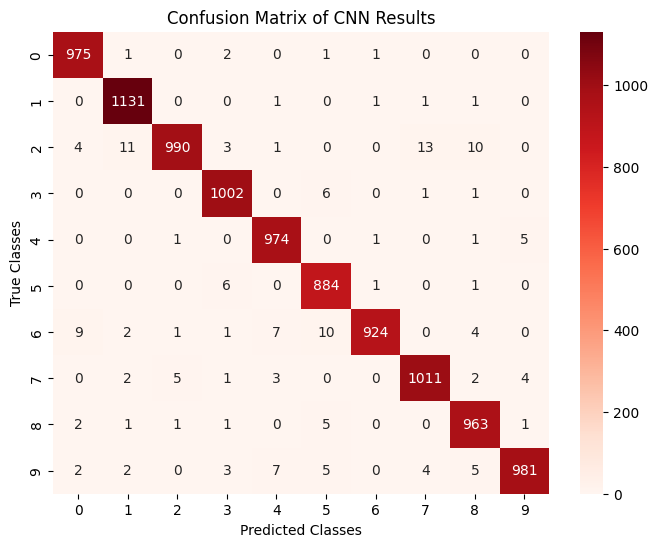

In [170]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap="Reds")
plt.xlabel("Predicted Classes")
plt.ylabel("True Classes")
plt.title("Confusion Matrix of CNN Results")
plt.show()